In [ ]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This python program is used to set up and run a data-assimilation 
and drift trajectory forecasting experiment.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


import sys, os, datetime, time, shutil
from importlib import reload 
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec as gridspec

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

from SWESimulators import IPythonMagic
from SWESimulators import BaseOceanStateEnsemble, OceanNoiseEnsemble, CDKLM16 
from SWESimulators import Common
from SWESimulators import DataAssimilationUtils as dautils



In [ ]:
%cuda_context_handler gpu_ctx
%setup_logging --out enkf_gpu.log --file_level 15

Console logger using level INFO
File logger using level Level 15 to enkf_gpu.log
Python version 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]


# Set up an instance 

OceanNoiseEnsemble using CDKLM16-Simulators: The CDKLM16 simulates the SWE on a rotational frame of reference on a small rectangular domain of sixe `dx`$\times$`dy` with a grid `nx`$\times$`ny` with periodic boundary conditions. As initial condition, all state variables are 0, what is a steady-state solution (lake at rest).

All ensemble members are initialized identically like the truth. Roughly speaking, the truth is simply one of the ensemble members. This is called an "identical twin experiment". 

In [ ]:
# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 60, "ny": 60,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    #"small_scale_perturbation": True,
    "small_scale_perturbation_interpolation_factor": 3,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals():
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(dautils)

sim = CDKLM16.CDKLM16(**sim_args)
#sim.perturbState(q0_scale=100)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 25,
    "num_drifters": 1,
    "sim": sim,
    #"observation_type" : dautils.ObservationType.DirectUnderlyingFlow,
    "observation_type": dautils.ObservationType.StaticBuoys,
    "buoys_positions" : [[120.0,120.0]],
    "observation_variance": 0.02**2,
    #"initialization_variance_factor_ocean_field" : 25.0,
    "ensemble_small_scale_perturbation" : True
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

print ("Ready!")



q0:  0.00017095320928897472
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (60, 60)
max_dt:  0.10096374899148941
Ready!


# Investigation of Initial Truth

The truth is generated by a random perturbation and the static buoy is placed in the middle of the domain

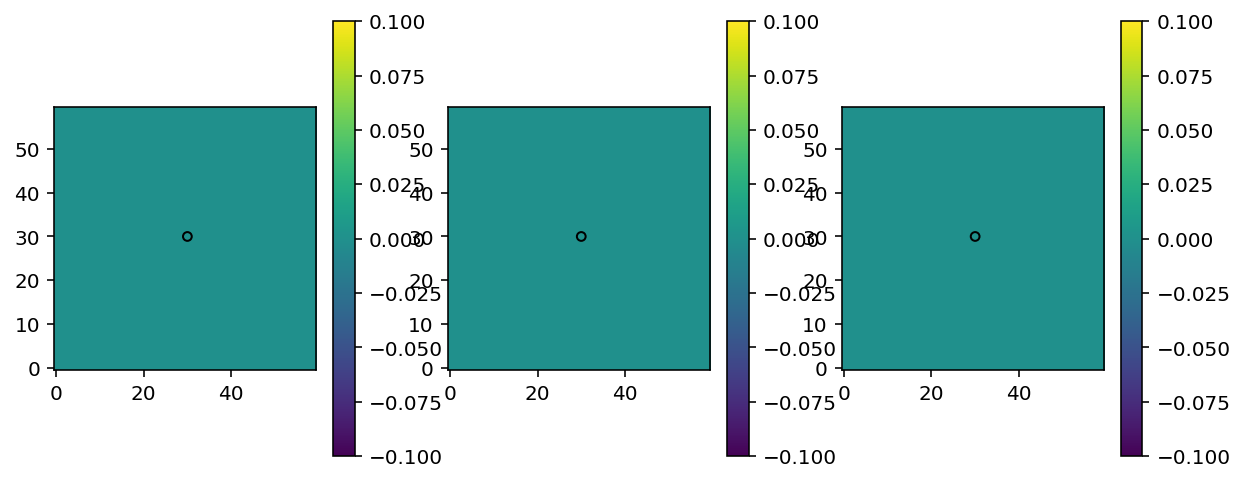

In [ ]:
# Visualize ocean initial true state

eta, hu, hv = sim.download(interior_domain_only=True)

fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,3,1)
plt.imshow(eta, origin="lower", interpolation="None")
plt.colorbar()

ax2 = plt.subplot(1,3,2)
plt.imshow(hu, origin="lower", interpolation="None")
plt.colorbar()

ax3 = plt.subplot(1,3,3)
plt.imshow(hv, origin="lower", interpolation="None")
plt.colorbar()

# Add marker for drifters

def _markDriftersInImshow(ax):
    
    observed_drifter_positions = ensemble.observeTrueState()[:][0:2]

    for d in range(ensemble.getNumDrifters()):
        cell_id_x = int(np.floor(observed_drifter_positions[d,0]/ensemble.getDx()))
        cell_id_y = int(np.floor(observed_drifter_positions[d,1]/ensemble.getDy()))
        circ = matplotlib.patches.Circle((cell_id_x, cell_id_y), 1, fill=False)
        ax.add_patch(circ)

_markDriftersInImshow(ax1)
_markDriftersInImshow(ax3)
_markDriftersInImshow(ax2)

# Run Simulation and perform DA at Observation Times

In contrast to the classical formulation of a data assimilation problem, the (small scale) model error is added after every simulation time step (and not just at every observation time) - this allows to consider statistics in "continuous" time. 

After every simulation time step, the ensemble are perturbed with the same scheme as in the DA Paper Eqs (21-26). After a random perturbtion, this is smoothed using SOAR with $q_0=\frac{\texttt{dx}}{10^5}$ on a coarse grid (see `interpolation_factor`), interpolated on the fine grid and geostrophically balanced. 

In [ ]:
sys.path.insert(0, os.getcwd())
import EnKFOcean
reload(EnKFOcean)

# Parameters for data assimilation
t = 0.0
idx_obs = 0

t_obs = [5.0,10.0,15.0,20.0,25.0]
t_max = 40.0

EnKFOcean = EnKFOcean.EnKFOcean(ensemble)

# Parameters for statistical evaluation
t_steps = 0.5 # step length when statistics are evaluated  
fields = np.zeros((len(t_obs), ensemble.getNumParticles(), 3, sim.ny, sim.nx, 2))
field_true = np.zeros((len(t_obs),3,sim.ny,sim.nx))

while t < t_max:
    print("t = ", t)
    
    ensemble.step(t)

    if t==t_obs[idx_obs]:
        print("EnKF for observation time t = ", t)

        # Store fields before DA
        for p in range(ensemble.getNumParticles()):
            eta, hu, hv = ensemble.downloadParticleOceanState(p)
            fields[idx_obs, p, 0, :, :, 0] = eta
            fields[idx_obs, p, 1, :, :, 0] = hu
            fields[idx_obs, p, 2, :, :, 0] = hv
        eta, hu, hv = ensemble.particles[-1].download(interior_domain_only=True)
        field_true[idx_obs, 0, :, : ] = eta
        field_true[idx_obs, 1, :, : ] = hu
        field_true[idx_obs, 2, :, : ] = hv
        # (end) Store fields before DA

        EnKFOcean.EnKF(ensemble)

        # Store fields after DA 
        for p in range(ensemble.getNumParticles()):
            eta, hu, hv = ensemble.downloadParticleOceanState(p)
            fields[idx_obs, p, 0, :, :, 1] = eta
            fields[idx_obs, p, 1, :, :, 1] = hu
            fields[idx_obs, p, 2, :, :, 1] = hv
        # (end) Store fields after DA

        if idx_obs < len(t_obs)-1:
            idx_obs += 1

    ensemble.getEnsembleVarAndRMSEUnderDrifter(t)
    t = t + t_steps

print("Ready!")

t =  0.0
t =  0.5
t =  1.0
t =  1.5
t =  2.0
t =  2.5
t =  3.0
t =  3.5
t =  4.0
t =  4.5
t =  5.0
EnKF for observation time t =  5.0
t =  5.5
t =  6.0
t =  6.5
t =  7.0
t =  7.5
t =  8.0
t =  8.5
t =  9.0
t =  9.5
t =  10.0
EnKF for observation time t =  10.0
t =  10.5
t =  11.0
t =  11.5
t =  12.0
t =  12.5
t =  13.0
t =  13.5
t =  14.0
t =  14.5
t =  15.0
EnKF for observation time t =  15.0
t =  15.5
t =  16.0
t =  16.5
t =  17.0
t =  17.5
t =  18.0
t =  18.5
t =  19.0
t =  19.5
t =  20.0
EnKF for observation time t =  20.0
t =  20.5
t =  21.0
t =  21.5
t =  22.0
t =  22.5
t =  23.0
t =  23.5
t =  24.0
t =  24.5
t =  25.0
EnKF for observation time t =  25.0
t =  25.5
t =  26.0
t =  26.5
t =  27.0
t =  27.5
t =  28.0
t =  28.5
t =  29.0
t =  29.5
t =  30.0
t =  30.5
t =  31.0
t =  31.5
t =  32.0
t =  32.5
t =  33.0
t =  33.5
t =  34.0
t =  34.5
t =  35.0
t =  35.5
t =  36.0
t =  36.5
t =  37.0
t =  37.5
t =  38.0
t =  38.5
t =  39.0
t =  39.5
Ready!


# Statistical evaluation

## Evaluation at the observation point

In order to check the quality of the EnKF, we investigate the following properties evaluated at the buoy position:

Root mean square error compared to the truth:
$$RMSE = \sqrt{\frac{ \sum_{i=1}^{N_e} (\psi_i - \psi_{\text{true}})^2}{N_e}}$$

Standard deviation of ensemble:
$$ \sigma = \sqrt{\frac{ \sum_{i=1}^{N_e} (\psi_i - \bar{\psi})^2}{N_e-1}}$$

NB! Note the similarity in the formulas for RMSE and StDev. Since we can consider the syntethic truth as an additional realization of the ensemble, its deviation from the mean is stochastically the same as for all other ensemble members

(0.0, 2.0)

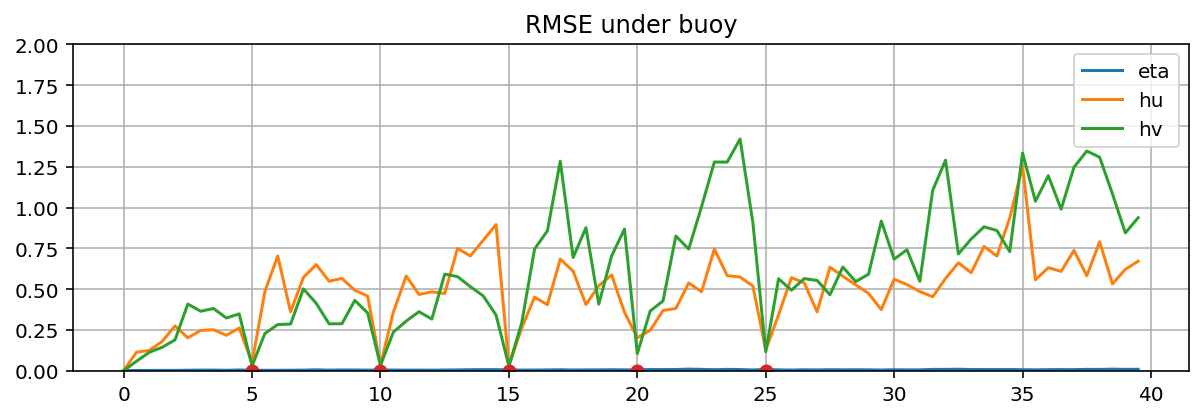

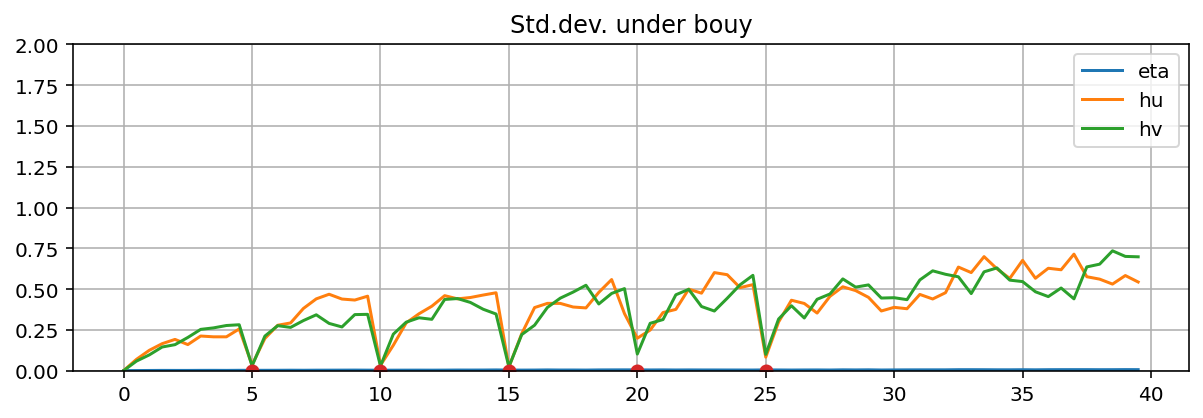

In [ ]:
fig = plt.figure(figsize=(10,3))
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_eta, label='eta')
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_hu,  label='hu')
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_hv,  label='hv')
plt.plot(t_obs, 0.0*np.ones_like(t_obs), 'o')
plt.title("RMSE under buoy")
plt.legend(loc=0)
plt.grid()
plt.ylim([0, 2])

# fig = plt.figure(figsize=(10,3))
# plt.plot(ensemble.tArray, ensemble.rmseWeightedUnderDrifter_eta, label='eta')
# plt.plot(ensemble.tArray, ensemble.rmseWeightedUnderDrifter_hu,  label='hu')
# plt.plot(ensemble.tArray, ensemble.rmseWeightedUnderDrifter_hv,  label='hv')
# plt.plot(t_obs, 0.0*np.ones_like(t_obs), 'o')
# plt.title("Weighted RMSE under buoy")
# plt.legend(loc=0)
# plt.grid()
# plt.ylim([0, 20])

# fig = plt.figure(figsize=(10,3))
# plt.plot(ensemble.tArray, ensemble.rmseMeanUnderDrifter_eta, label='eta')
# plt.plot(ensemble.tArray, ensemble.rmseMeanUnderDrifter_hu,  label='hu')
# plt.plot(ensemble.tArray, ensemble.rmseMeanUnderDrifter_hv,  label='hv')
# plt.plot(t_obs, 0.0*np.ones_like(t_obs), 'o')
# plt.title("REM under bouy")
# plt.legend(loc=0)
# plt.grid()
# plt.ylim([0, 20])

fig = plt.figure(figsize=(10,3))
plt.plot(ensemble.tArray, ensemble.varianceUnderDrifter_eta, label='eta')
plt.plot(ensemble.tArray, ensemble.varianceUnderDrifter_hu,  label='hu')
plt.plot(ensemble.tArray, ensemble.varianceUnderDrifter_hv,  label='hv')
plt.plot(t_obs, 0.0*np.ones_like(t_obs), 'o')
plt.title("Std.dev. under bouy")
plt.legend(loc=0)
plt.grid()
plt.ylim([0, 2])

#### Observation:
Comparing $RMSE_{truth}$ with $\sigma$, we see a similar magnitude and similar behaviour: At observation times the statistical quantities tend to $0$ whereas in the forecast phase after the last observation the ensemble goes wild. The standard deviation shows a smoother behaviour, since it compares with the average and not to the one "true" realization.


## Evaluation of the fields

The RMSE is evaluated similar to the cell above, but now it is visualized over the complete field before and after the data assimilation at observation times

In [ ]:
def plotRMSEFieldsBeforeAndAfterDA(ensemble, field_true, fields, idx_obs):

    # mean before
    eta_mean_before = np.zeros((field_true.shape[2], field_true.shape[3]))
    hu_mean_before  = np.zeros((field_true.shape[2], field_true.shape[3]))
    hv_mean_before  = np.zeros((field_true.shape[2], field_true.shape[3]))

    for p in range(fields.shape[0]):
        eta_mean_before += 1/fields.shape[0] * fields[idx_obs, p, 0, :, :, 0]
        hu_mean_before  += 1/fields.shape[0] * fields[idx_obs, p, 1, :, :, 0]
        hv_mean_before  += 1/fields.shape[0] * fields[idx_obs, p, 2, :, :, 0]

    # rmse and stdev before
    eta_rmse_before = np.zeros((field_true.shape[2], field_true.shape[3]))
    hu_rmse_before  = np.zeros((field_true.shape[2], field_true.shape[3]))
    hv_rmse_before  = np.zeros((field_true.shape[2], field_true.shape[3]))

    eta_stdev_before = np.zeros((field_true.shape[2], field_true.shape[3]))
    hu_stdev_before  = np.zeros((field_true.shape[2], field_true.shape[3]))
    hv_stdev_before  = np.zeros((field_true.shape[2], field_true.shape[3]))
        
    for p in range(fields.shape[0]):
        eta_rmse_before += 1/fields.shape[0] * (field_true[idx_obs, 0, :, :] - fields[idx_obs, p, 0, :, :, 0])**2
        hu_rmse_before  += 1/fields.shape[0] * (field_true[idx_obs, 1, :, :] - fields[idx_obs, p, 1, :, :, 0])**2
        hv_rmse_before  += 1/fields.shape[0] * (field_true[idx_obs, 2, :, :] - fields[idx_obs, p, 2, :, :, 0])**2

        eta_stdev_before += 1/(fields.shape[0]-1) * (eta_mean_before - fields[idx_obs, p, 0, :, :, 0])**2
        hu_stdev_before  += 1/(fields.shape[0]-1) * (hu_mean_before  - fields[idx_obs, p, 1, :, :, 0])**2
        hv_stdev_before  += 1/(fields.shape[0]-1) * (hv_mean_before  - fields[idx_obs, p, 2, :, :, 0])**2

    eta_stdev_before = np.sqrt(eta_stdev_before)
    hu_stdev_before  = np.sqrt(hu_stdev_before)
    hv_stdev_before  = np.sqrt(hv_stdev_before)

    # < before || after >

    # mean after
    eta_mean_after = np.zeros((field_true.shape[2], field_true.shape[3]))
    hu_mean_after  = np.zeros((field_true.shape[2], field_true.shape[3]))
    hv_mean_after  = np.zeros((field_true.shape[2], field_true.shape[3]))

    for p in range(fields.shape[0]):
        eta_mean_after += 1/fields.shape[0] * fields[idx_obs, p, 0, :, :, 1]
        hu_mean_after  += 1/fields.shape[0] * fields[idx_obs, p, 1, :, :, 1]
        hv_mean_after  += 1/fields.shape[0] * fields[idx_obs, p, 2, :, :, 1]

    # rmse and stdev after
    eta_rmse_after = np.zeros((field_true.shape[2], field_true.shape[3]))
    hu_rmse_after  = np.zeros((field_true.shape[2], field_true.shape[3]))
    hv_rmse_after  = np.zeros((field_true.shape[2], field_true.shape[3]))

    eta_stdev_after = np.zeros((field_true.shape[2], field_true.shape[3]))
    hu_stdev_after  = np.zeros((field_true.shape[2], field_true.shape[3]))
    hv_stdev_after  = np.zeros((field_true.shape[2], field_true.shape[3]))

    for p in range(fields.shape[0]):
        eta_rmse_after += 1/fields.shape[0] * (field_true[idx_obs, 0, :, :] - fields[idx_obs, p, 0, :, :, 1])**2
        hu_rmse_after  += 1/fields.shape[0] * (field_true[idx_obs, 1, :, :] - fields[idx_obs, p, 1, :, :, 1])**2
        hv_rmse_after  += 1/fields.shape[0] * (field_true[idx_obs, 2, :, :] - fields[idx_obs, p, 2, :, :, 1])**2

        eta_stdev_after += 1/(fields.shape[0]-1) * (eta_mean_after - fields[idx_obs, p, 0, :, :, 1])**2
        hu_stdev_after  += 1/(fields.shape[0]-1) * (hu_mean_after  - fields[idx_obs, p, 1, :, :, 1])**2
        hv_stdev_after  += 1/(fields.shape[0]-1) * (hv_mean_after  - fields[idx_obs, p, 2, :, :, 1])**2

    eta_stdev_after = np.sqrt(eta_stdev_after)
    hu_stdev_after  = np.sqrt(hu_stdev_after)
    hv_stdev_after  = np.sqrt(hv_stdev_after)

    # difference before minus after 
    eta_rmse_diff = eta_rmse_after - eta_rmse_before
    hu_rmse_diff  = hu_rmse_after  - hu_rmse_before
    hv_rmse_diff  = hv_rmse_after  - hv_rmse_before

    eta_stdev_diff = eta_stdev_after - eta_stdev_before
    hu_stdev_diff  = hu_stdev_after  - hu_stdev_before
    hv_stdev_diff  = hv_stdev_after  - hv_stdev_before


    # Plotting

    # Plotting RMSE
    clim_eta = 0.0001
    clim_huv = 2.0

    fig = plt.figure(figsize=(10,10))

    ax1 = plt.subplot(3,3,1)
    ax1.title.set_text('$\eta$ RMSE before DA')
    _markDriftersInImshow(ax1)
    plt.imshow(eta_rmse_before, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0, clim_eta)
    plt.colorbar()

    ax2 = plt.subplot(3,3,2)
    ax2.title.set_text('$\eta$ RMSE after DA')
    _markDriftersInImshow(ax2)
    plt.imshow(eta_rmse_after, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0, clim_eta)
    plt.colorbar()

    ax3 = plt.subplot(3,3,3)
    ax3.title.set_text('$\eta$ RMSE diff')
    _markDriftersInImshow(ax3)
    plt.imshow(eta_rmse_diff, origin="lower", interpolation="None", cmap="seismic")
    plt.clim(-0.5*clim_eta,0.5*clim_eta)
    plt.colorbar()

    ax4 = plt.subplot(3,3,4)
    ax4.title.set_text('$hu$ RMSE before DA')
    _markDriftersInImshow(ax4)
    plt.imshow(hu_rmse_before, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0,clim_huv)
    plt.colorbar()

    ax5 = plt.subplot(3,3,5)
    ax5.title.set_text('$hu$ RMSE after DA')
    _markDriftersInImshow(ax5)
    plt.imshow(hu_rmse_after, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0,clim_huv)
    plt.colorbar()

    ax6 = plt.subplot(3,3,6)
    ax6.title.set_text('$hu$ RMSE diff')
    _markDriftersInImshow(ax6)
    plt.imshow(hu_rmse_diff, origin="lower", interpolation="None", cmap="seismic")
    plt.clim(-0.5*clim_huv,0.5*clim_huv)
    plt.colorbar()

    ax7 = plt.subplot(3,3,7)
    ax7.title.set_text('$hv$ RMSE before DA')
    _markDriftersInImshow(ax7)
    plt.imshow(hv_rmse_before, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0,clim_huv)
    plt.colorbar()

    ax8 = plt.subplot(3,3,8)
    ax8.title.set_text('$hv$ RMSE after DA')
    _markDriftersInImshow(ax8)
    plt.imshow(hv_rmse_after, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0,clim_huv)
    plt.colorbar()

    ax9 = plt.subplot(3,3,9)
    ax9.title.set_text('$hv$ RMSE diff')
    _markDriftersInImshow(ax9)
    plt.imshow(hv_rmse_diff, origin="lower", interpolation="None", cmap="seismic")
    plt.clim(-0.5*clim_huv,0.5*clim_huv)
    plt.colorbar()

    plt.show()

    # Plotting STDEV
    clim_eta = 0.01
    clim_huv = 1.0

    fig = None
    fig = plt.figure(figsize=(10,10))

    ax1 = plt.subplot(3,3,1)
    ax1.title.set_text('$\eta$ STDEV before DA')
    _markDriftersInImshow(ax1)
    plt.imshow(eta_stdev_before, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0, clim_eta)
    plt.colorbar()

    ax2 = plt.subplot(3,3,2)
    ax2.title.set_text('$\eta$ STDEV after DA')
    _markDriftersInImshow(ax2)
    plt.imshow(eta_stdev_after, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0, clim_eta)
    plt.colorbar()

    ax3 = plt.subplot(3,3,3)
    ax3.title.set_text('$\eta$ STDEV diff')
    _markDriftersInImshow(ax3)
    plt.imshow(eta_stdev_diff, origin="lower", interpolation="None", cmap="seismic")
    plt.clim(-0.25*clim_eta,0.25*clim_eta)
    plt.colorbar()

    ax4 = plt.subplot(3,3,4)
    ax4.title.set_text('$hu$ STDEV before DA')
    _markDriftersInImshow(ax4)
    plt.imshow(hu_stdev_before, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0,clim_huv)
    plt.colorbar()

    ax5 = plt.subplot(3,3,5)
    ax5.title.set_text('$hu$ STDEV after DA')
    _markDriftersInImshow(ax5)
    plt.imshow(hu_stdev_after, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0,clim_huv)
    plt.colorbar()

    ax6 = plt.subplot(3,3,6)
    ax6.title.set_text('$hu$ STDEV diff')
    _markDriftersInImshow(ax6)
    plt.imshow(hu_stdev_diff, origin="lower", interpolation="None", cmap="seismic")
    plt.clim(-0.25*clim_huv,0.25*clim_huv)
    plt.colorbar()

    ax7 = plt.subplot(3,3,7)
    ax7.title.set_text('$hv$ STDEV before DA')
    _markDriftersInImshow(ax7)
    plt.imshow(hv_stdev_before, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0,clim_huv)
    plt.colorbar()

    ax8 = plt.subplot(3,3,8)
    ax8.title.set_text('$hv$ STDEV after DA')
    _markDriftersInImshow(ax8)
    plt.imshow(hv_stdev_after, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(0.0,clim_huv)
    plt.colorbar()

    ax9 = plt.subplot(3,3,9)
    ax9.title.set_text('$hv$ STDEV diff')
    _markDriftersInImshow(ax9)
    plt.imshow(hv_stdev_diff, origin="lower", interpolation="None", cmap="seismic")
    plt.clim(-0.25*clim_huv,0.25*clim_huv)
    plt.colorbar()

    # Plotting means 

    clim_eta = 0.01
    clim_huv = 1.0

    fig = None
    fig = plt.figure(figsize=(10,10))

    ax1 = plt.subplot(3,3,1)
    ax1.title.set_text('$\eta$ mean before DA')
    _markDriftersInImshow(ax1)
    plt.imshow(eta_mean_before, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(-clim_eta, clim_eta)
    plt.colorbar()

    ax2 = plt.subplot(3,3,2)
    ax2.title.set_text('$\eta$ true')
    _markDriftersInImshow(ax2)
    plt.imshow(field_true[idx_obs, 0, :, :], origin="lower", interpolation="None", cmap="inferno")
    plt.clim(-clim_eta, clim_eta)
    plt.colorbar()

    ax3 = plt.subplot(3,3,3)
    ax3.title.set_text('$\eta$ mean after DA')
    _markDriftersInImshow(ax3)
    plt.imshow(eta_mean_after, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(-clim_eta,clim_eta)
    plt.colorbar()

    ax4 = plt.subplot(3,3,4)
    ax4.title.set_text('$hu$ mean before DA')
    _markDriftersInImshow(ax4)
    plt.imshow(hu_mean_before, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(-clim_huv,clim_huv)
    plt.colorbar()

    ax5 = plt.subplot(3,3,5)
    ax5.title.set_text('$hu$ true')
    _markDriftersInImshow(ax5)
    plt.imshow(field_true[idx_obs, 1, :, :], origin="lower", interpolation="None", cmap="inferno")
    plt.clim(-clim_huv,clim_huv)
    plt.colorbar()

    ax6 = plt.subplot(3,3,6)
    ax6.title.set_text('$hu$ mean after DA')
    _markDriftersInImshow(ax6)
    plt.imshow(hu_mean_after, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(-clim_huv,clim_huv)
    plt.colorbar()

    ax7 = plt.subplot(3,3,7)
    ax7.title.set_text('$hv$ mean before DA')
    _markDriftersInImshow(ax7)
    plt.imshow(hv_mean_before, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(-clim_huv,clim_huv)
    plt.colorbar()

    ax8 = plt.subplot(3,3,8)
    ax8.title.set_text('$hv$ true')
    _markDriftersInImshow(ax8)
    plt.imshow(field_true[idx_obs, 2, :, :], origin="lower", interpolation="None", cmap="inferno")
    plt.clim(-clim_huv,clim_huv)
    plt.colorbar()

    ax9 = plt.subplot(3,3,9)
    ax9.title.set_text('$hv$ mean after DA')
    _markDriftersInImshow(ax9)
    plt.imshow(hv_mean_after, origin="lower", interpolation="None", cmap="inferno")
    plt.clim(-clim_huv,clim_huv)
    plt.colorbar()

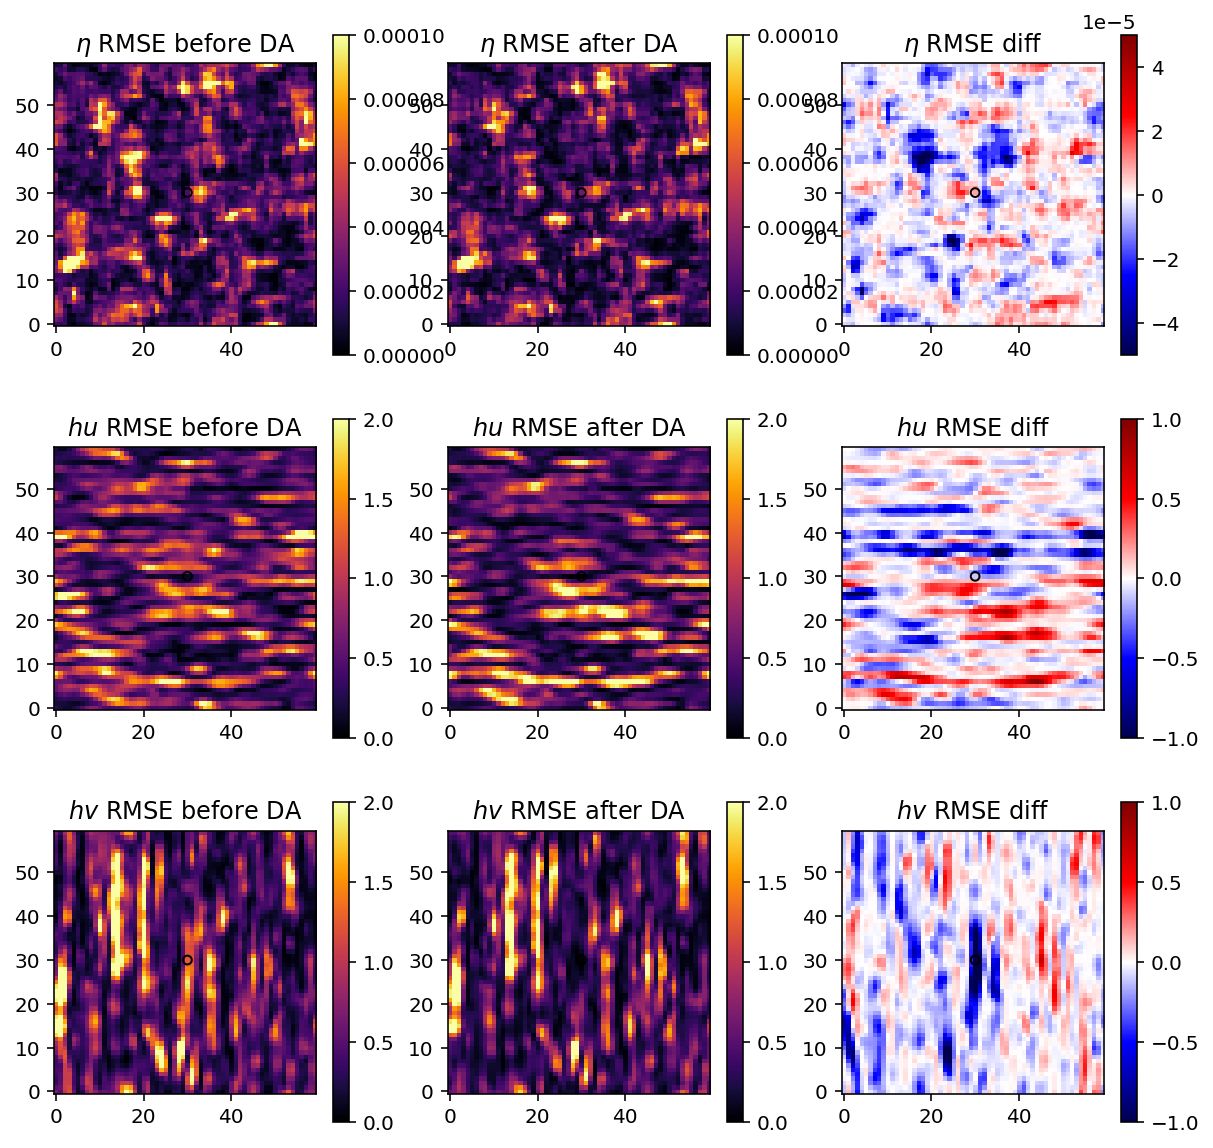

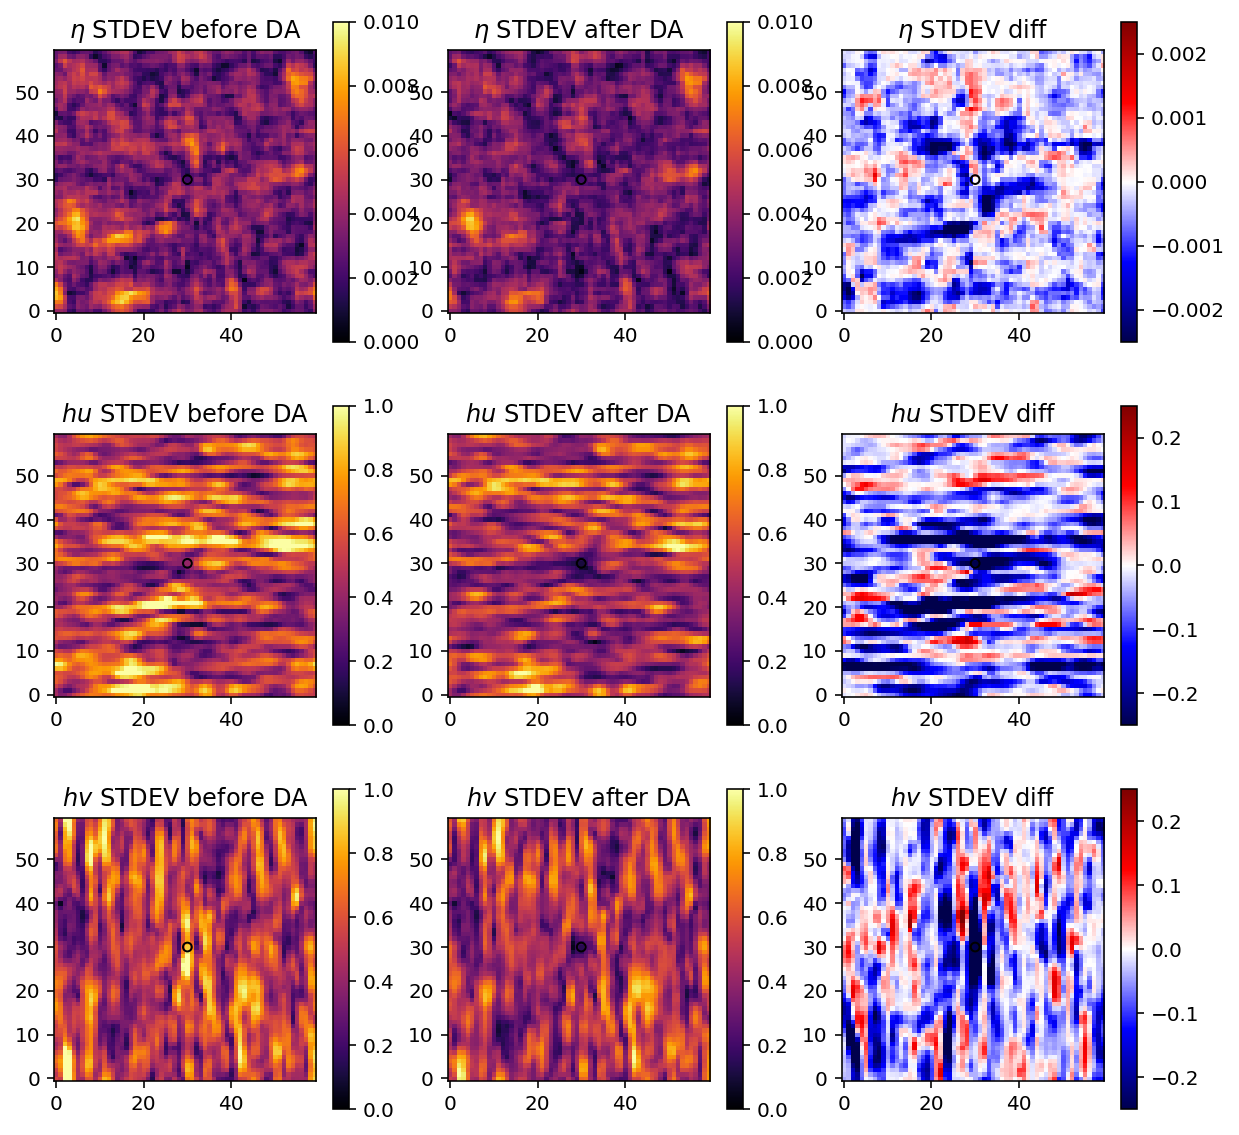

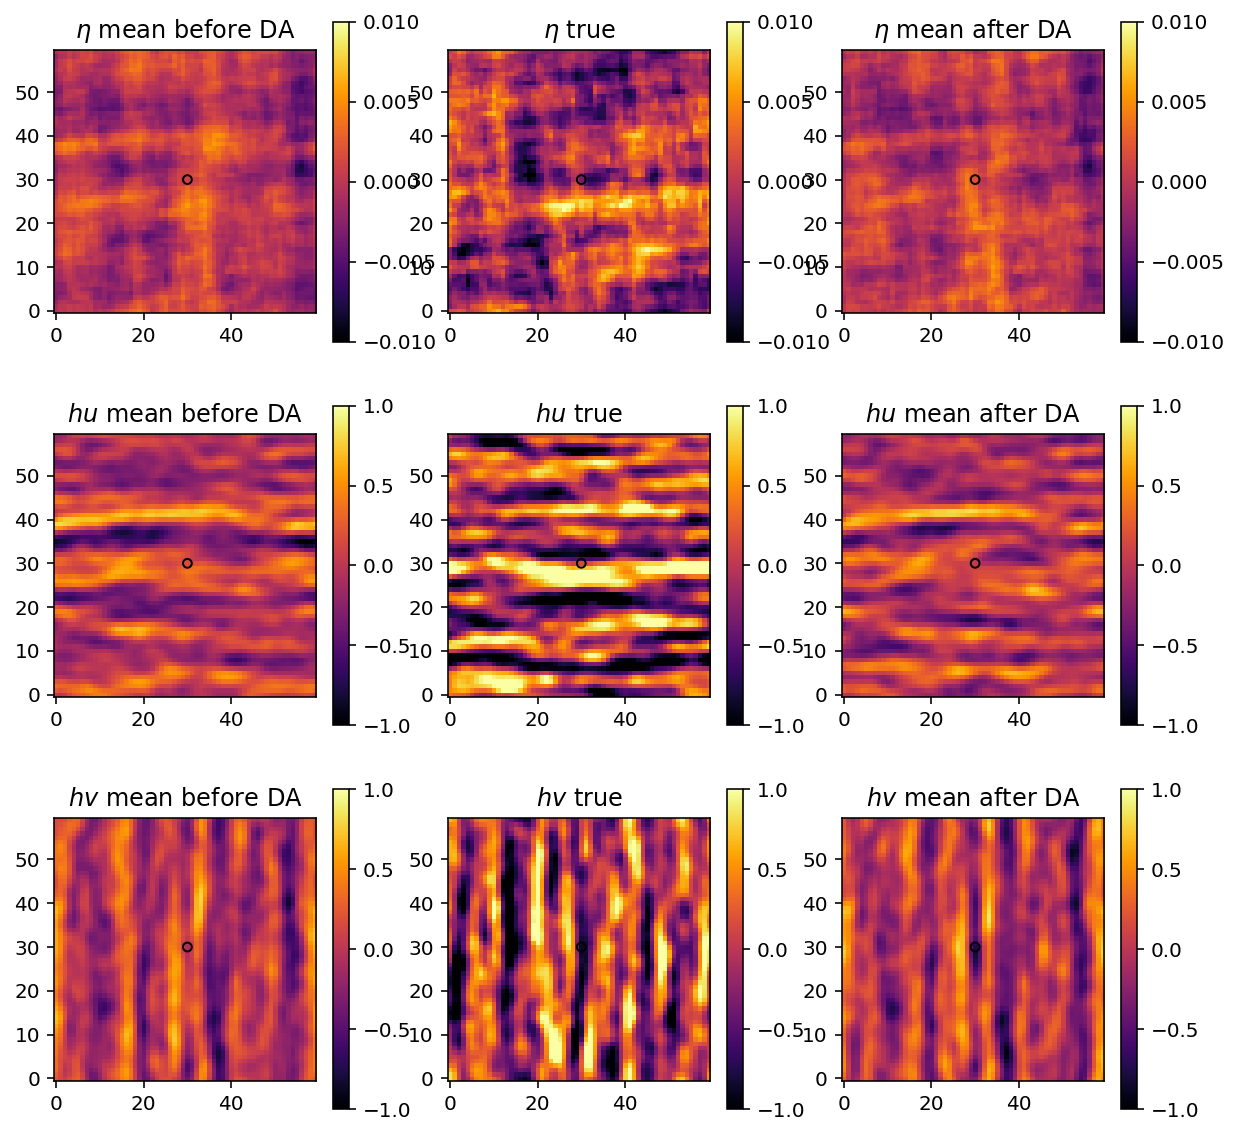

In [ ]:
plotRMSEFieldsBeforeAndAfterDA(ensemble, field_true, fields, 4)